In [1]:
import numpy as np
import pandas as pd

# Aggregate and Clean Train Data

### 3 sources of training data: 

#### Obach et al. (2006)

In [2]:
obach_vdss = pd.read_csv('../data/Obach_Vdss/resolved_obach_train.csv') \
    .rename(columns={"VDss (L/kg)": "human_VDss_L/kg"}) \
    .assign(source='Obach_2006')

#### Lombardo et al. (2018)

In [3]:
lombardo_vdss = pd.read_csv('../data/Lombardo_PK/resolved_pk_train.csv') \
    .rename(columns={"fraction unbound \nin plasma (fu)": "human_fup",
                     "moka_ionState7.4": "moka_ion_state_pH7.4",
                     "human VDss (L/kg)": "human_VDss_L/kg",
                     "MoKa.LogD7.4": "moka_logD_7.4"}) \
    .assign(source='Lombardo_2018')

#### Berellini and Lombardo (2019)

In [4]:
berellini_vdss = pd.read_csv('../data/Lombardo_Vdss/resolved_vdss_train.csv') \
    .rename(columns={'human VDss(L/kg)': 'human_VDss_L/kg',
                     'human fup': 'human_fup'}) \
    .assign(source='Berellini_Lombardoque_2019')

## Combine the datasets

In [5]:
ber_trim = berellini_vdss[['std_smiles', 'inchi_key', 'human_VDss_L/kg', 'source']]
lom_trim = lombardo_vdss[['std_smiles', 'inchi_key', 'human_VDss_L/kg', 'source']]
obach_trim = obach_vdss[['std_smiles', 'inchi_key', 'human_VDss_L/kg', 'source']]

combined = pd.concat([ber_trim, lom_trim, obach_trim]) \
    .drop_duplicates(subset=['inchi_key', 'human_VDss_L/kg'], keep='first') \
    .reset_index(drop=True)


### Look at duplicate smiles that don't agree on $VD_{ss}$

Looks like two of the compounds are off by an order of magnitude. We're going to drop those entirely. 

In [6]:
dupes = list(combined.inchi_key.value_counts().reset_index().loc[lambda x:x.inchi_key > 1]['index'])

In [7]:
combined.loc[lambda x:x.inchi_key.isin(dupes)].sort_values('inchi_key')

,std_smiles,inchi_key,human_VDss_L/kg,source
874,CCCc1nn(C)c2c(=O)[nH]c(-c3cc(S(=O)(=O)N4CCN(C)...,BNRNXUUZRGQAQC-UHFFFAOYSA-N,1.36,Lombardo_2018
1374,CCCc1nn(C)c2c(=O)[nH]c(-c3cc(S(=O)(=O)N4CCN(C)...,BNRNXUUZRGQAQC-UHFFFAOYSA-N,1.40,Obach_2006
193,CN(C)CCCN1c2ccccc2CCc2ccc(Cl)cc21,GDLIGKIOYRNHDA-UHFFFAOYSA-N,13.00,Berellini_Lombardoque_2019
1511,CN(C)CCCN1c2ccccc2CCc2ccc(Cl)cc21,GDLIGKIOYRNHDA-UHFFFAOYSA-N,140.00,Obach_2006
1161,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)...,STQGQHZAVUOBTE-VGBVRHCVSA-N,32.05,Lombardo_2018
1581,COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)...,STQGQHZAVUOBTE-VGBVRHCVSA-N,0.95,Obach_2006
768,CSc1ccc(C(=O)c2[nH]c(=O)[nH]c2C)cc1,ZJKNESGOIKRXQY-UHFFFAOYSA-N,1.48,Lombardo_2018
1362,CSc1ccc(C(=O)c2[nH]c(=O)[nH]c2C)cc1,ZJKNESGOIKRXQY-UHFFFAOYSA-N,1.80,Obach_2006


In [8]:
losers = ['GDLIGKIOYRNHDA-UHFFFAOYSA-N',
          'STQGQHZAVUOBTE-VGBVRHCVSA-N']

In [9]:
print('Combined records:', combined.shape[0])

combined_trim = combined \
    .loc[lambda x:~ x.inchi_key.isin(losers)] \
    .groupby(['inchi_key']) \
    .agg({'human_VDss_L/kg':'mean',
          'source': 'min',
          'std_smiles': 'min'})  \
    .reset_index()

print('Cleaned records:', combined_trim.shape[0])

combined_trim.head(2)

Combined records: 1636
Cleaned records: 1630


,inchi_key,human_VDss_L/kg,source,std_smiles
0,AAKJLRGGTJKAMG-UHFFFAOYSA-N,0.77,Lombardo_2018,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1
1,AAOVKJBEBIDNHE-UHFFFAOYSA-N,1.00,Berellini_Lombardoque_2019,CN1C(=O)CN=C(c2ccccc2)c2cc(Cl)ccc21


# Prepare Test Data

### Convert Names to SMILES
https://stackoverflow.com/questions/54930121/converting-molecule-name-to-smiles

In [23]:
from urllib.request import urlopen
import ssl

# Create a temporary unverified context in case SSL verification isn't configured
ssl._create_default_https_context = ssl._create_unverified_context

def CIRconvert(ids):
    try:
        url = 'http://cactus.nci.nih.gov/chemical/structure/' + ids + '/smiles'
        ans = urlopen(url).read().decode('utf8')
        return ans
    except:
        return 'Did not work'

In [24]:
all_preds = pd.read_csv('../data/Petersson_Vdss/Petersson_all_preds.csv') \
    .apply(lambda x: x.str.strip() if x.dtype == "object" else x) \
    .dropna(how='all', axis=1) \
    .dropna(how='all', axis=0) \
    .rename(columns=lambda x: x.strip())

exp_ref = pd.read_csv('../data/Petersson_Vdss/Petersson_exp_ref.csv') \
    .apply(lambda x: x.str.strip() if x.dtype == "object" else x) \
    .iloc[:106:] \
    .rename(columns=lambda x: x.strip())

In [22]:
%%time

### This takes a minute... 

merge_df = pd.merge(all_preds, exp_ref, on='Name') \
    .assign(SMILES= lambda x: [CIRconvert(n) for n in x.Name]) \
    .rename(columns={'Human VD_x': 'human_VDss_L/kg'})

CPU times: user 311 ms, sys: 109 ms, total: 420 ms
Wall time: 43.4 s


#### Unfortunately couldn't find out what cmet orange is and it's the only unreferenced compound in the dataset.

Soucing the rest of the SMILES from PubChem manually ... the glamorous life of a cheminformaticist.

In [25]:
list(merge_df.loc[lambda x:x.SMILES == "Did not work"].Name)

['Crizotinib',
 'Hydrodolasetron',
 'Isosorbide dinitrate',
 'Isosorbide mononitrate',
 'Pazopanib',
 'Ro25-6833',
 'Valproic Acd',
 'cmet orange']

In [26]:
missing_smiles = pd.DataFrame(
    {'Crizotinib': ['C[C@H](C1=C(C=CC(=C1Cl)F)Cl)OC2=C(N=CC(=C2)C3=CN(N=C3)C4CCNCC4)N'],
     'Hydrodolasetron': ['C1C2CC3CC(CC1N3CC2O)OC(=O)C4=CNC5=CC=CC=C54'],
     'Isosorbide dinitrate': ['C1[C@H]([C@@H]2[C@H](O1)[C@H](CO2)O[N+](=O)[O-])O[N+](=O)[O-]'],
     'Isosorbide mononitrate': ['C1[C@@H]([C@@H]2[C@H](O1)[C@@H](CO2)O[N+](=O)[O-])O'],
     'Pazopanib': ['CC1=C(C=C(C=C1)NC2=NC=CC(=N2)N(C)C3=CC4=NN(C(=C4C=C3)C)C)S(=O)(=O)N'],
     'Ro25-6833': ['C\\1CN(C(=O)/C1=C/C2=C(N3[C@@H]([C@@H](C3=O)NC(=O)/C(=N\\O)/C4=CSC(=N4)N)SC2)C(=O)O)CC(F)(F)F'],
     'Valproic Acd': ['CCCC(CCC)C(=O)O'],
     'cmet orange': ['None']}).T.reset_index() \
    .rename(columns={'index': 'Name',
                     0: 'SMILES'})

In [27]:
# Placing the manually determined values back into the dataset.
for row in missing_smiles.iterrows():
    
    merge_df.loc[lambda x:x.Name == row[1].Name, 'SMILES'] = row[1].SMILES

In [28]:
## Take the first 24 columns and the last
merge_df \
    .iloc[:, list(range(24)) + [-1]] \
    .to_csv('../data/Petersson_Vdss/Petersson_combined_smiles.csv', index=False)

## After standardizing with `opnbnchmark` tools

In [29]:
test_df = pd.read_csv('../data/Petersson_Vdss/resolved_Petersson_combined_smiles.csv')

print("Test compounds:", test_df.shape[0])

test_df[['std_smiles']].to_csv('../data/Vdss_combined/test_smi/Petersson_test_smi.csv', index=False)

Test compounds: 105


In [30]:
train_final = pd.merge(combined_trim, test_df, how='left', on=['inchi_key', 'std_smiles'], indicator=True) \
    .loc[lambda x:x._merge == 'left_only'] \
    .dropna(axis=1, how='all') \
    .drop(columns={'_merge'})
    
train_final \
    .loc[::, ['std_smiles', 'human_VDss_L/kg_x']] \
    .rename(columns={'human_VDss_L/kg_x': 'human_VDss_L/kg'}) \
    .to_csv('../data/Vdss_combined/vdss_Petersson_train.csv', index=False)

print("Uncontaminated train records:", train_final.shape[0])

train_final.head(3)

Uncontaminated train records: 1557


,inchi_key,human_VDss_L/kg_x,source,std_smiles
0,AAKJLRGGTJKAMG-UHFFFAOYSA-N,0.77,Lombardo_2018,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1
1,AAOVKJBEBIDNHE-UHFFFAOYSA-N,1.00,Berellini_Lombardoque_2019,CN1C(=O)CN=C(c2ccccc2)c2cc(Cl)ccc21
2,ACCMWZWAEFYUGZ-UHFFFAOYSA-N,0.61,Lombardo_2018,CCOCCn1c(C2CCN(CCc3ccc(C(C)(C)C(=O)O)cc3)CC2)n...


# Incorporate the predictions

In [31]:
preds = pd.read_csv('../data/Vdss_combined/preds/scaff_prod_preds.csv') \
    .rename(columns={'human_VDss_L/kg': 'log_VDss_OB_pred'}) \
    .assign(human_VDss_OB_pred = lambda x:10**x.log_VDss_OB_pred)

preds.head(2)

,std_smiles,log_VDss_OB_pred,human_VDss_OB_pred
0,CC(C)NCC(O)COc1ccc(COCCOC(C)C)cc1,0.253922,1.794412
1,C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)...,0.081297,1.205860


In [32]:
test_preds = pd.merge(test_df, preds)
test_preds['ion class'] = test_preds['ion class'] \
    .replace(['B', 'Z', 'A', 'N'],['Base', 'Zwitterion', 'Acid', 'Neutral'])

test_preds.head(2)

,VDu Rat-Dog-Monkey,OT Rat-Dog,Ion class average,ion class,OT Dog-Monkey,MLR(Rat-Dog),Allometry VD Rat-Dog-Monkey,value_col,OT Rat,Rogers-Lucova,...,VDu Rat,SSS Rat,VDu Dog-Monkey,SMILES,std_smiles,std_relation,human_VDss_L/kg,inchi_key,log_VDss_OB_pred,human_VDss_OB_pred
0,2.31,1.52,2.20,Base,2.35,1.41,5.91,2.4,1.09,1.67,...,1.09,0.97,2.92,CC(C)NCC(O)COc1ccc(COCCOC(C)C)cc1,CC(C)NCC(O)COc1ccc(COCCOC(C)C)cc1,=,2.4,VHYCDWMUTMEGQY-UHFFFAOYSA-N,0.253922,1.794412
1,2.06,1.39,0.83,Zwitterion,1.09,1.68,0.84,1.2,3.45,0.77,...,3.38,2.48,1.40,C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc4C(=O)C(=CN1c24...,C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)...,=,1.2,GSDSWSVVBLHKDQ-JTQLQIEISA-N,0.081297,1.205860


# Analyze the predictions

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr

sys.path.append('../data_analysis/')

from Metrics import gmfe_score, n_fold_perc, afe_score
from Viz.pred_exp_viz import PredExpViz

In [34]:
def pretty_plot(df, xcol, ycol, hue_col, xlabel, ylabel, title):
    """
    Building a plot that inherits from the opnbnchmark PredExpViz class
    """
    
    TV = PredExpViz(df=df, xcol=xcol, ycol=ycol, hue_col=hue_col)
    
    TV.main()
    TV.add_unity()
    TV.add_nfold_error(n=2)
    TV.add_axis_labels(xlabel, ylabel)
    TV.add_title(title)
    
    x = TV.x
    y = TV.y
    

    aafe = gmfe_score.gmfe_score(x, y)
    twofold_perc = n_fold_perc.n_fold_perc(x, y, 2)
    afe = afe_score.afe_score(x, y)
    
    TV.ax.text(0.2, 24, f"$AAFE = {aafe:.02f}$", fontsize=18, fontweight='bold')
    TV.ax.text(0.2, 18, f"$AFE = {afe:.02f}$", fontsize=18, fontweight='bold')
    TV.ax.text(0.2, 33, f"2-fold % $= {twofold_perc:.00f}$", fontsize=18)

In [35]:
test_preds.columns

Index(['VDu Rat-Dog-Monkey', 'OT Rat-Dog', 'Ion class average', 'ion class',
       'OT Dog-Monkey', 'MLR(Rat-Dog)', 'Allometry VD Rat-Dog-Monkey',
       'value_col', 'OT Rat', 'Rogers-Lucova', 'VDu Monkey', 'Name',
       'OT Monkey', 'VDu Rat-Monkey', 'SSS Monkey', 'OT Dog', 'VDu Rat-Dog',
       'VDu allometry Rat-Dog-Monkey', 'SSS Dog', 'OT Rat-Monkey', 'VDu Dog',
       'VDu Rat', 'SSS Rat', 'VDu Dog-Monkey', 'SMILES', 'std_smiles',
       'std_relation', 'human_VDss_L/kg', 'inchi_key', 'log_VDss_OB_pred',
       'human_VDss_OB_pred'],
      dtype='object')

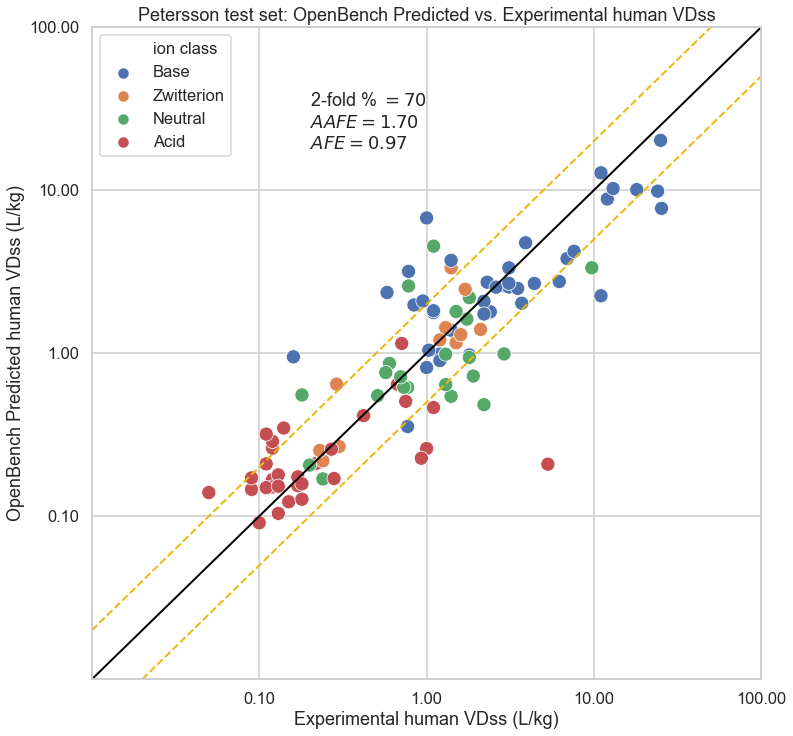

In [36]:
xlab = 'Experimental human VDss (L/kg)'
ylab = 'OpenBench Predicted human VDss (L/kg)'
title = 'Petersson test set: OpenBench Predicted vs. Experimental human VDss'

pretty_plot(test_preds, 
            xcol='human_VDss_L/kg', ycol='human_VDss_OB_pred', hue_col='ion class',
            xlabel=xlab, ylabel=ylab, title=title)

In [37]:
### A look at our worst predictions

test_preds \
    .assign(fold_error = 10**np.abs(np.log10(test_preds['human_VDss_L/kg'] / test_preds['human_VDss_OB_pred']))) \
    .sort_values('fold_error', ascending=False) \
    .loc[::, ['Name', 'std_smiles', 'ion class', 'human_VDss_L/kg', 'human_VDss_OB_pred', 'fold_error']] \
    .head()

,Name,std_smiles,ion class,human_VDss_L/kg,human_VDss_OB_pred,fold_error
100,Telmisartan,CCCc1nc2c(C)cc(-c3nc4ccccc4n3C)cc2n1Cc1ccc(-c2...,Acid,5.30,0.208488,25.421089
68,Nicardipine,COC(=O)C1=C(C)NC(C)=C(C(=O)OCCN(C)Cc2ccccc2)C1...,Base,1.00,6.742903,6.742903
38,Pazopanib,Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S...,Base,0.16,0.949151,5.932193
28,Hydrodolasetron,O=C(OC1CC2CC3CC(C1)N2CC3O)c1c[nH]c2ccccc12,Base,11.00,2.247019,4.895374
47,Coumarin,O=c1ccc2ccccc2o1,Neutral,2.20,0.483001,4.554859


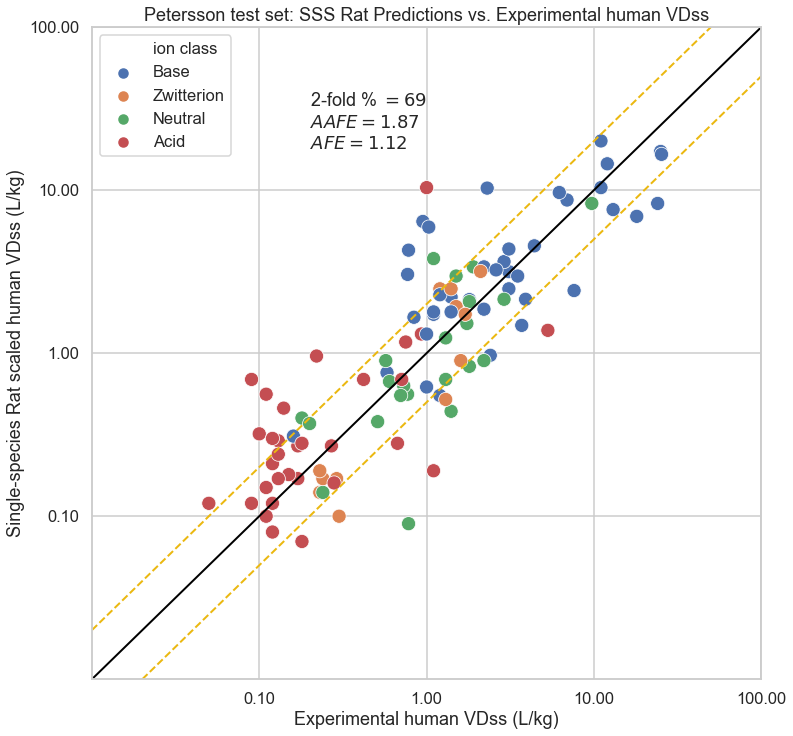

In [38]:
### Edit the ycol to analyze predictions and metrics associated with other efforts! 
### Remember we're missing one test set compound, "cmet orange," which changes the numbers ever so slightly.

xlab = 'Experimental human VDss (L/kg)'
ylab = 'Single-species Rat scaled human VDss (L/kg)'
title = 'Petersson test set: SSS Rat Predictions vs. Experimental human VDss'

pretty_plot(test_preds, 
            xcol='human_VDss_L/kg', ycol='SSS Rat', hue_col='ion class',
            xlabel=xlab, ylabel=ylab, title=title)